<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook3_Volatility_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Volatility Forecasting

This notebook forecasts 7-day volatility using multiple regression models.

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


## Data Collection

Defines a list of 10 popular ETFs across different asset classes and geographies.

Sets the date range to the last 10 years by calculating today's date minus 120 months.

Setup a clean, consolidated, and analysis-ready dataset of 10 ETFs over 10 years.

Combines all the reshaped data (Open, High, Low, Close, Volume) into a single flat DataFrame.

This dataset shall be used as input for all feature engineering and modeling steps in volatility prediction, signal classification, and price forecasting.

In [ ]:

# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25170, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
1 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
2 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
3 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
4 2015-04-17    EEM  34.12  34.24  34.30  34.04  76688000
            Date Ticker    Open   Close    High     Low    Volume
25165 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25166 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25167 2025-04-09    XLV  130.13  138.76  139.24  129.68  39444700
25168 2025-04-10    XLV  137.70  134.89  137.74  131.33  21956900
25169 2025-04-11    XLV  135.15  135.12  135.68  133.67   2691433
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25170 entries, 0 to 25169
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25170 non-null 

## Feature Engineering

Important Block
Calculates Daily Returns, as it is fundamental for volatility prediction and trend identification.

Computes 20-day rolling standard deviation of returns, as that is the norm to identify recent volatility

MA 5 - 20-day simple moving average (despite the name suggesting 5).

Close MA5diff - Percent difference between the current price and moving average.

SMA smooths trends. EMA gives more weight to recent prices (better for fast trend shifts).

ATR7 - 7-day average of True Range.

ATR7_pct - Normalized ATR — more useful across ETFs with different price ranges.

RSI14- a 14-day momentum oscillator to measure recent gain vs losses

%K- Where the current price stands within the 14-day high/low range.

%D- 3-day moving average of %K (smoothed version).

Dates to capture seasonality and calendar effects on price/volatility


In [ ]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-3-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25170, 29)


# Target Variable

Rolling Standard Deviation - Volatility over 7 days.
COmputes 7 days forward
Features used (X for features used for prediction, and y for target)
Train vs Test Split at 80% and 20%

In [ ]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Rolling_Std_7'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(7).std().shift(-7))
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Rolling_Std_7']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


### Linear Regression
Baseline Regression model
RMSE - Penalizes larger errors more heavily. Interpreted in same units as target.

MAE - Average of absolute differences between predictions and actual values.

R2 - Explains how much variance in y_test is explained by the model (1 = perfect)
If train error < test error → Overfitting

If both errors are high → Underfitting

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Test prediction and evaluation
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f" Test-LR-RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

# Train prediction and evaluation
y_train_pred_lr = lr.predict(X_train)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)
print(f" Train-LR-RMSE: {rmse_train_lr:.4f}, MAE: {mae_train_lr:.4f}, R2: {r2_train_lr:.4f}")


 Test-LR-RMSE: 0.4202, MAE: 0.2808, R2: 0.4976
 Train-LR-RMSE: 1.1157, MAE: 0.6064, R2: 0.6706


### Random Forest Regression
RandomForest with default hyperparameters
Ensemble of Decision Tree


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Test prediction and evaluation
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Test-RF-RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

# Train prediction and evaluation
y_train_pred_rf = rf.predict(X_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Train-RF-RMSE: {rmse_train_rf:.4f}, MAE: {mae_train_rf:.4f}, R2: {r2_train_rf:.4f}")


Test-RF-RMSE: 0.4422, MAE: 0.3157, R2: 0.4437
Train-RF-RMSE: 0.2889, MAE: 0.1572, R2: 0.9779


### XGBoost Regression

Gradient Boosting Model - builds trees sequentially to correct the errors of the previous tree.

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Test prediction and evaluation
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Test-XGBoost-RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")

# Train prediction and evaluation
y_train_pred_xgb = xgb.predict(X_train)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
print(f"Train-XGBoost-RMSE: {rmse_train_xgb:.4f}, MAE: {mae_train_xgb:.4f}, R2: {r2_train_xgb:.4f}")


Test-XGBoost-RMSE: 0.4500, MAE: 0.3070, R2: 0.4239
Train-XGBoost-RMSE: 0.3847, MAE: 0.2711, R2: 0.9608


### LSTM Regression

Construct sequential time window for LSTM Modelling

Done at each ticker independently, extract historical of 7 days worth of features.

Train and Test

Train the model, 64 memory units and Final layer with 1 neuron to predict volatility

adam - efficient GB optimiser

Early stop has been added, half training if validation does not improve for 5 epochs.

Trains the model for 10 epochs. Use 10% of the training data for validation. Min batch size of 32.

Overfitting (train < test)

Underfitting (both errors high)

Good generalization (train = test)





In [ ]:
# Rebuild sequence data for LSTM
def create_lstm_sequences(data, target, lookback=7):
    X_lstm, y_lstm = [], []
    for ticker in data['Ticker'].unique():
        df_ticker = data[data['Ticker'] == ticker].reset_index(drop=True)
        for i in range(lookback, len(df_ticker) - 7):
            X_lstm.append(df_ticker[features].iloc[i - lookback:i].values)
            y_lstm.append(df_ticker[target].iloc[i])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_sequences(df, 'Rolling_Std_7')
X_train_lstm, X_test_lstm = X_lstm[:int(0.8 * len(X_lstm))], X_lstm[int(0.8 * len(X_lstm)):]
y_train_lstm, y_test_lstm = y_lstm[:int(0.8 * len(y_lstm))], y_lstm[int(0.8 * len(y_lstm)):]

# Build model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stop])

# Test evaluation
y_pred_lstm = lstm_model.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"Test-LSTM-RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")

# Train evaluation
y_train_pred_lstm = lstm_model.predict(X_train_lstm)
rmse_lstm_train = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred_lstm))
mae_lstm_train = mean_absolute_error(y_train_lstm, y_train_pred_lstm)
r2_lstm_train = r2_score(y_train_lstm, y_train_pred_lstm)
print(f"Train-LSTM-RMSE: {rmse_lstm_train:.4f}, MAE: {mae_lstm_train:.4f}, R2: {r2_lstm_train:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 4.3178 - val_loss: 1.9379
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.6175 - val_loss: 1.9682
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.3483 - val_loss: 2.0124
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.5046 - val_loss: 2.0309
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.4917 - val_loss: 1.9149
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5725 - val_loss: 2.0418
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.5326 - val_loss: 1.9688
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.6767 - val_loss: 2.0133
Epoch 9/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.4837 - val_loss: 2.0063
Epoch 10/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.4490 - val_loss: 1.9650
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test-LSTM-RMSE: 1.1070, MAE: 1.0287, R2: -2.7107
575/575 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train-

# Ensemble (Linear + Random Forest+ XGBoost)

trains different models independently on the same training data
LR - simple regression ( to capture trends)
RF - decision tree (non-linearity)
XGB - gradient boosted decision tree (non-linearity)

Takes average of the three outputs



In [ ]:
# Train models
lr_model = LinearRegression().fit(X_train, y_train)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb_model = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

# Predict - Test
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_ensemble = (y_pred_lr + y_pred_rf + y_pred_xgb) / 3

# Predict - Train
y_train_lr = lr_model.predict(X_train)
y_train_rf = rf_model.predict(X_train)
y_train_xgb = xgb_model.predict(X_train)
y_train_ensemble = (y_train_lr + y_train_rf + y_train_xgb) / 3

# Evaluate Test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
mae_test = mean_absolute_error(y_test, y_pred_ensemble)
r2_test = r2_score(y_test, y_pred_ensemble)

# Evaluate - Train
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_ensemble))
mae_train = mean_absolute_error(y_train, y_train_ensemble)
r2_train = r2_score(y_train, y_train_ensemble)

print("Ensemble Volatility Forecasting")
print(f"Test-RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")
print(f"Train-RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")


Ensemble Volatility Forecasting
Test-RMSE: 0.4122, MAE: 0.2803, R²: 0.5167
Train-RMSE: 0.5468, MAE: 0.3281, R²: 0.9209


## Final Comparison & Best Model Selection

In [ ]:
import pandas as pd

# Store results as dictionaries for each metric set
results_test = {
    'Linear Regression': (rmse_lr, mae_lr, r2_lr),
    'Random Forest': (rmse_rf, mae_rf, r2_rf),
    'XGBoost': (rmse_xgb, mae_xgb, r2_xgb),
    'LSTM': (rmse_lstm, mae_lstm, r2_lstm),
    'Ensemble': (rmse_test, mae_test, r2_test)
}

results_train = {
    'Linear Regression': (rmse_train_lr, mae_train_lr, r2_train_lr),
    'Random Forest': (rmse_train_rf, mae_train_rf, r2_train_rf),
    'XGBoost': (rmse_train_xgb, mae_train_xgb, r2_train_xgb),
    'LSTM': (rmse_lstm_train, mae_lstm_train, r2_lstm_train),
    'Ensemble': (rmse_train, mae_train, r2_train)
}

# Convert to DataFrames
df_test = pd.DataFrame(results_test, index=['RMSE_Test', 'MAE_Test', 'R2_Test']).T
df_train = pd.DataFrame(results_train, index=['RMSE_Train', 'MAE_Train', 'R2_Train']).T

# Combine both
df_combined = pd.concat([df_train, df_test], axis=1)

# Sort by RMSE_Test ascending
df_combined_sorted = df_combined.sort_values(by='RMSE_Test')

# Display
print(df_combined_sorted)



                   RMSE_Train  MAE_Train  R2_Train  RMSE_Test  MAE_Test  \
Ensemble             0.546787   0.328148  0.920874   0.412177  0.280288   
Linear Regression    1.115709   0.606430  0.670552   0.420218  0.280850   
Random Forest        0.288925   0.157240  0.977907   0.442175  0.315714   
XGBoost              0.384743   0.271101  0.960823   0.449994  0.306952   
LSTM                 1.845007   1.259993 -0.000250   1.107045  1.028699   

                    R2_Test  
Ensemble           0.516656  
Linear Regression  0.497613  
Random Forest      0.443740  
XGBoost            0.423893  
LSTM              -2.710687  


# Graphs

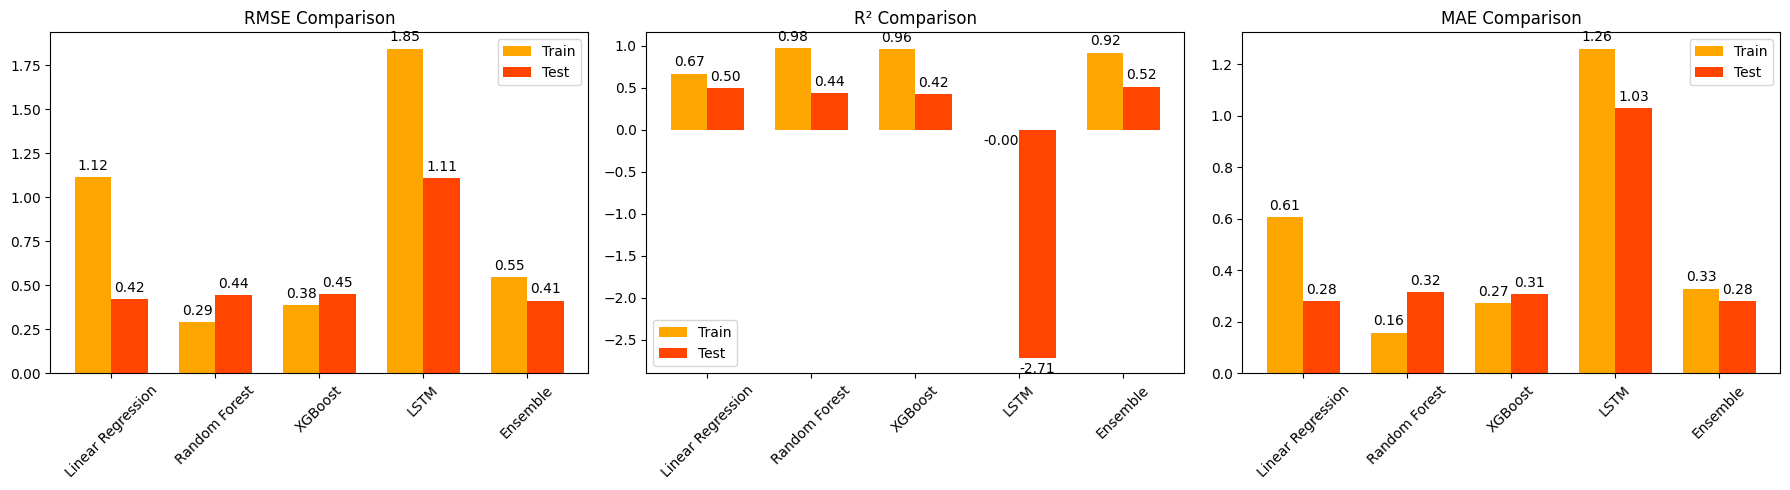

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample metrics from your previous output
metrics_data = {
    'Linear Regression': (rmse_train_lr, mae_train_lr, r2_train_lr),
    'Random Forest': (rmse_train_rf, mae_train_rf, r2_train_rf),
    'XGBoost': (rmse_train_xgb, mae_train_xgb, r2_train_xgb),
    'LSTM': (rmse_lstm_train, mae_lstm_train, r2_lstm_train),
    'Ensemble': (rmse_train, mae_train, r2_train)
}

df_metrics = pd.DataFrame(metrics_data, index=['RMSE_Train', 'MAE_Train', 'R2_Train']).transpose()
df_metrics[['RMSE_Test', 'MAE_Test', 'R2_Test']] = [
    (rmse_lr, mae_lr, r2_lr),
    (rmse_rf, mae_rf, r2_rf),
    (rmse_xgb, mae_xgb,
     r2_xgb),
    (rmse_lstm, mae_lstm, r2_lstm),
    (rmse_test, mae_test, r2_test)
]


#
models = df_metrics.index.tolist()
x = np.arange(len(models))
width = 0.35

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
bars1 = axs[0].bar(x - width/2, df_metrics["RMSE_Train"], width, label='Train', color='orange')
bars2 = axs[0].bar(x + width/2, df_metrics["RMSE_Test"], width, label='Test', color='orangered')
axs[0].set_title("RMSE Comparison")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45)
axs[0].legend()
axs[0].bar_label(bars1, fmt='%.2f', padding=3)
axs[0].bar_label(bars2, fmt='%.2f', padding=3)

# R²
bars1 = axs[1].bar(x - width/2, df_metrics["R2_Train"], width, label='Train', color='orange')
bars2 = axs[1].bar(x + width/2, df_metrics["R2_Test"], width, label='Test', color='orangered')
axs[1].set_title("R² Comparison")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45)
axs[1].legend()
axs[1].bar_label(bars1, fmt='%.2f', padding=3)
axs[1].bar_label(bars2, fmt='%.2f', padding=3)

# MAE
bars1 = axs[2].bar(x - width/2, df_metrics["MAE_Train"], width, label='Train', color='orange')
bars2 = axs[2].bar(x + width/2, df_metrics["MAE_Test"], width, label='Test', color='orangered')
axs[2].set_title("MAE Comparison")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=45)
axs[2].legend()
axs[2].bar_label(bars1, fmt='%.2f', padding=3)
axs[2].bar_label(bars2, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()



<ipython-input-16-460a641d36d1>:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


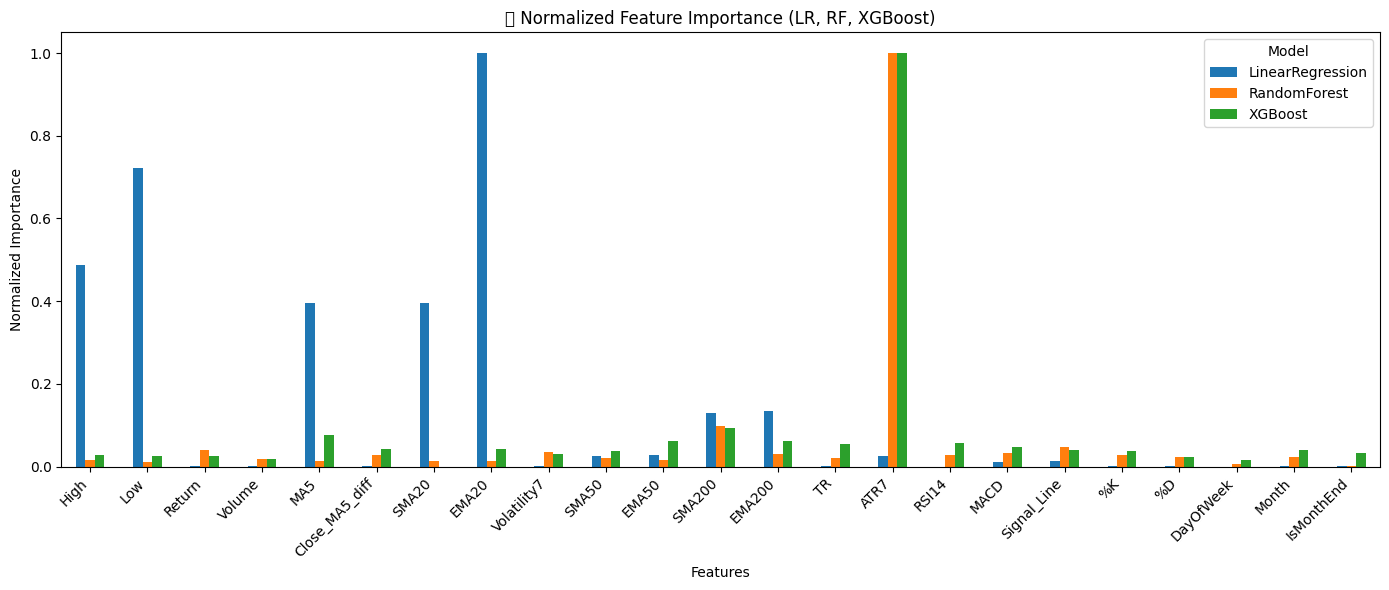

In [ ]:
# Feature importance from Linear Regression
lr_importance = np.abs(lr_model.coef_)
# With this:
lr_series = pd.Series(lr_importance, index=features, name="LinearRegression")
rf_series = pd.Series(rf_model.feature_importances_, index=features, name="RandomForest")
xgb_series = pd.Series(xgb_model.feature_importances_, index=features, name="XGBoost")

features = ['High', 'Low', 'Return', 'Volume', 'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20',
            'Volatility7', 'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7', 'RSI14',
            'MACD', 'Signal_Line', '%K', '%D', 'DayOfWeek', 'Month', 'IsMonthEnd']


# Feature importance from Random Forest
rf_importance = rf_model.feature_importances_


# Feature importance from XGBoost
xgb_importance = xgb_model.feature_importances_


# Combine
importance_df = pd.concat([lr_series, rf_series, xgb_series], axis=1)

# Normalize for better comparability
importance_df_norm = importance_df / importance_df.max()

# Plot all
importance_df_norm.plot(kind="bar", figsize=(14, 6))
plt.title("🔍 Normalized Feature Importance (LR, RF, XGBoost)")
plt.ylabel("Normalized Importance")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Model")
plt.show()


# To Generate Output

In [ ]:
# Step before training
df['Rolling_STD_7'] = (
    df.sort_values(['Ticker', 'Date'])
      .groupby('Ticker')['Return']
      .rolling(window=7)
      .std()
      .shift(-7)
      .reset_index(level=0, drop=True)
)

#
forecast_days = 7
today = datetime.today().date()

# Generate next 7 days
future_dates = []
while len(future_dates) < forecast_days:
    today+= timedelta(days=1)
    if today.weekday() < 5:  # Mon–Fri
        future_dates.append(today)

# Prepare latest data
latest_df = df.groupby("Ticker").tail(1).copy().reset_index(drop=True)
future_df = pd.DataFrame(np.repeat(latest_df.values, forecast_days, axis=0), columns=latest_df.columns)
future_df["Date"] = future_dates * len(latest_df)


for col in features:
    if pd.api.types.is_numeric_dtype(future_df[col]):
        std_dev = future_df[col].std()
        if std_dev > 0:
            future_df[col] += np.random.normal(0, 0.01 * std_dev, size=len(future_df))



# Features
features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D',
    'DayOfWeek', 'Month', 'IsMonthEnd']


scaler = StandardScaler()
X_full = scaler.fit_transform(df[features])
X_future = scaler.transform(future_df[features])

X_future += np.random.normal(0, 0.01, X_future.shape)

# Train base models
y = df['Rolling_STD_7']  # Your volatility target


# Filter rows where target is not NaN
valid_rows = ~y.isna()
X_full_clean = X_full[valid_rows]
y_clean = y[valid_rows]

model_lr = LinearRegression().fit(X_full_clean, y_clean)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_full_clean, y_clean)
model_xgb = XGBRegressor(n_estimators=100, random_state=42).fit(X_full_clean, y_clean)


# Predict
pred_lr = model_lr.predict(X_future)
pred_rf = model_rf.predict(X_future)
pred_xgb = model_xgb.predict(X_future)

# Simple average ensemble
future_df['Predicted_Volatility'] = (pred_lr + pred_rf + pred_xgb) / 3

# Output result
final_output = future_df[['Ticker', 'Date', 'Predicted_Volatility']]
print(final_output)

# Optionally export
final_output.to_csv("volatility.csv", index=False)


   Ticker        Date  Predicted_Volatility
0     EEM  2025-04-14              0.010208
1     EEM  2025-04-15              0.010051
2     EEM  2025-04-16              0.010171
3     EEM  2025-04-17              0.010089
4     EEM  2025-04-18              0.009465
..    ...         ...                   ...
65    XLV  2025-04-16              0.007923
66    XLV  2025-04-17              0.008234
67    XLV  2025-04-18              0.008112
68    XLV  2025-04-21              0.007619
69    XLV  2025-04-22              0.008052

[70 rows x 3 columns]
